<a href="https://colab.research.google.com/github/rickyhan24/Linear-Proofs-NLP/blob/main/Linear_Proofs_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Generating the Data**

In [ ]:
#Defining a template for our proofs in prefix notation
def prefix_proof(a:int, b:int, d:int) -> str:
    e = \
f""" 0. {a} {b} {d} 
 1. = + * {a} x {b} {d} 
 2. = - + * {a} x {b} {b} - {d} {b} 
 3. = + * {a} x 0 - {d} {b} 
 4. = * {a} x - {d} {b} 
 5. = / * {a} x {a} / - {d} {b} {a} 
 6. = * {1} x / - {d} {b} {a} 
 7. = x / {d - b} {a}"""

    return e

In [ ]:
#Defining a template for our proofs in infix notation
def infix_proof(a:int, b:int, d:int) -> str:
    e = \
    f"""0. {a} {b} {d}
 1. {a} * x + {b} = {d}\tGiven
 2. {a} * x + {b} - {b} = {d} - {b}\tSubtraction Property of Equality
 3. {a} * x + 0 = {d} - {b}\tAdditive Inverse
 4. {a} * x = {d} - {b}\tAdditive identity
 5. {a} * x / {a} = ( {d} - {b} ) / {a}\tDivision Property of Equality a != 0
 6. {1} * x = ( {d} - {b} ) / {a}\tMultiplicative Inverses
 7. x = ( {d} - {b} ) / {a}\tMultiplicative Identity
 8. x = ( {d} - {b} ) / {a}\tCanonical Equivalent Equation"""
    return e

In [ ]:
#Defining the proof generator that will generate lots of proofs
def proof_generator(na=2, nb=2, nc=2):
    
    for a in range(1, na):
        for b in range(1, nb):
            for d in range(1, nc):
                p = infix_proof(a, b, d)
#                 print(p)
#                 print()
                yield p + ' \n\n'

In [ ]:
#Creating a list of a bunch of proofs
proof_lines = []
for proof in proof_generator(11,11,11):
    proof_lines.append(proof)

# **Data Preprocessing**

In [ ]:
#Importing tensorflow
import tensorflow as tf


In [ ]:
#Importing libraries and dependencies
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow.keras.utils as ku
import numpy as np

In [ ]:
#Assigning tokens to each math symbol, newline symbol, step number, and double newline symbol in our dataset of proofs
tokenizer = Tokenizer(filters='')
tokenizer.fit_on_texts(proof_lines, )
total_words = len(tokenizer.word_index) + 1 #Adding 1 for the 0 in padding

In [ ]:
#Creating a list of tokenized n-grams from each proof
proof_line_encodings = []
for proof_line in proof_lines:
    proof_line_tokens = tokenizer.texts_to_sequences([proof_line])[0]
    for n in range(1, len(proof_line_tokens)):
        n_gram_tokens = proof_line_tokens[:n + 1]
        proof_line_encodings.append(n_gram_tokens)

#Padding the tokenized n-grams with max length equal to maximum length of all proofs
max_line_proof_encoding_len = max([len(proof_line_encoding) for proof_line_encoding in proof_line_encodings])
padded_proof_line_encodings = np.array(pad_sequences(proof_line_encodings, maxlen=max_line_proof_encoding_len, padding='pre'))

#Defining predictors as tokens of n-grams except last token and label as the last token
predictors, label = padded_proof_line_encodings[:,:-1], padded_proof_line_encodings[:,-1]

#One-hot-encoding the label with respect to vocabulary of tokens
label = ku.to_categorical(label, num_classes=total_words)

In [ ]:
#Splitting the predictors and label sets into training and test sets
from sklearn.model_selection import train_test_split
predictors_train, predictors_test, label_train, label_test = train_test_split(predictors, label, test_size=0.2, random_state = 4)

In [ ]:
#Finding the unique tokens in the predictors_train and the unique tokens in predictors_test and seeing if any tokens lie in their symmetric difference
array_train = np.array([],dtype='int32')
for i in range(0,len(predictors_train)):
  array_train = np.append(array_train,predictors_train[i])

array_test = np.array([],dtype='int32')
for i in range(0,len(predictors_test)):
  array_test = np.append(array_test,predictors_test[i])

set(array_train).symmetric_difference(set(array_test))

# **Building the Model**

In [ ]:
#Importing libraries and dependencies
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

In [ ]:
#Building the model

input_length = predictors.shape[1]

model = Sequential([
    Embedding(total_words, 128, input_length=input_length),
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.2),
    LSTM(128),
    Dense(total_words/2, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(total_words, activation='softmax'),
])

In [ ]:
#Compiling the model

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

In [ ]:
# 40 epochs
history = model.fit(predictors_train, label_train, epochs=15, verbose=1)

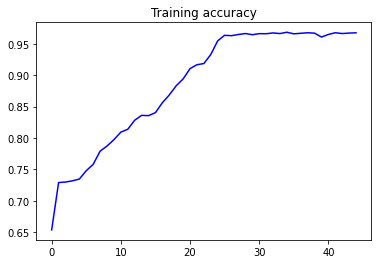

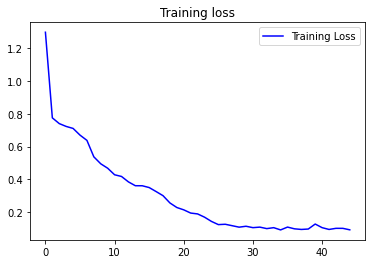

In [ ]:
#Plotting the accuracy and loss curves

import matplotlib.pyplot as plt
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [ ]:
#Finding the test accuracy
predicted_indices = ku.to_categorical(np.argmax(model.predict(predictors_test), axis=-1), num_classes=total_words)
num_correct = 0
for i in range(0,len(label_test)) :
  if all(predicted_indices[i] == label_test[i]):
    num_correct +=1
print(f'{(num_correct/len(label_test))*100}'+'% accuracy')

97.3252427184466% accuracy


In [ ]:
#Saving the model
model.save('linear_proofs_lstm_model_train_test_split_97percent.h5')

#Saving tokenizer
from pickle import dump, load
dump(tokenizer, open('my_tokenizer','wb'))

In [ ]:
#Using a saved model and tokenizer
from pickle import dump, load
from keras.models import load_model
model = load_model('linear_proofs_lstm_model_train_test_split.h5')
#tokenizer = load(open('my_tokenizer','rb'))

# **Applying the Model to Generate Text**

In [ ]:
#Defining a function that generates the next num_next_words words of the proof given a seed_text
def generate_text(model,tokenizer,input_length,seed_text, num_next_words):
  
    for _ in range(num_next_words):

      encoded_text = tokenizer.texts_to_sequences([seed_text])[0]
      pad_encoded_text = pad_sequences([encoded_text], maxlen=input_length, padding='pre')
      predicted_index = np.argmax(model.predict(pad_encoded_text), axis=-1)[0]
      predicted_word = tokenizer.index_word[predicted_index]
      seed_text += " " + predicted_word
    
    return seed_text

In [ ]:
#Specifying the number of first words and the number of next words
num_first_words = 12
num_next_words = max_line_proof_encoding_len-num_first_words
input_length = predictors.shape[1]
#Joining via space the first num_first_words words of a proof to create the seed_text
seed_text = ' '.join(proof_lines[987].split(' ')[:num_first_words])

#Generating the rest of the proof given the seed_text and number of next words
print(generate_text(model,tokenizer,input_length,seed_text, num_next_words))

0. 10 9 8
 1. 10 * x + 9 = 8	Given
 2. 10 * x + 9 - 9 = 8 - 9	subtraction property of equality
 3. 10 * x + 0 = 8 - 9	additive inverse
 4. 10 * x = 8 - 9	additive identity
 5. 10 * x / 10 = ( 8 - 9 ) / 10	division property of equality a != 0
 6. 1 * x = ( 8 - 9 ) / 10	multiplicative inverses
 7. x = ( 8 - 9 ) / 10	multiplicative identity
 8. x = ( 8 - 9 ) / 10	canonical equivalent equation 




In [ ]:
#Creating a dictionary of problem/proof pairs
dictionary = {}

for i in range(0,1000):
  seed_text = ' '.join(proof_lines[i].split(' ')[:num_first_words])
  dictionary[proof_lines[i]]=generate_text(model,tokenizer,input_length,seed_text, num_next_words)

In [ ]:
#Saving the dictionary
from pickle import dump, load
file_to_write = open("dictionary.pickle", "wb")
dump(dictionary, file_to_write)


In [ ]:
#Loading the dictionary
loaded_dictionary = load( open( "dictionary.pickle", "rb" ) )


In [ ]:
#Counting the number of correct proofs by comparing the key/value pairs in the dictionary
num_correct = 0

for proof_line in proof_lines:

  if proof_line.lower() == dictionary[proof_line].lower():
      num_correct +=1

print(f'{(num_correct/len(proof_lines))*100}'+'% accuracy')

100.0% accuracy
